
Model: XGBoost No Protected (Unweighted)
Training Time: 0.74 seconds
Accuracy: 0.8082
ROC AUC: 0.7285
PR AUC: 0.8955
CV ROC AUC: 0.7302 ± 0.0023
Class 1 - Precision: 0.8173, Recall: 0.9755, F1: 0.8894


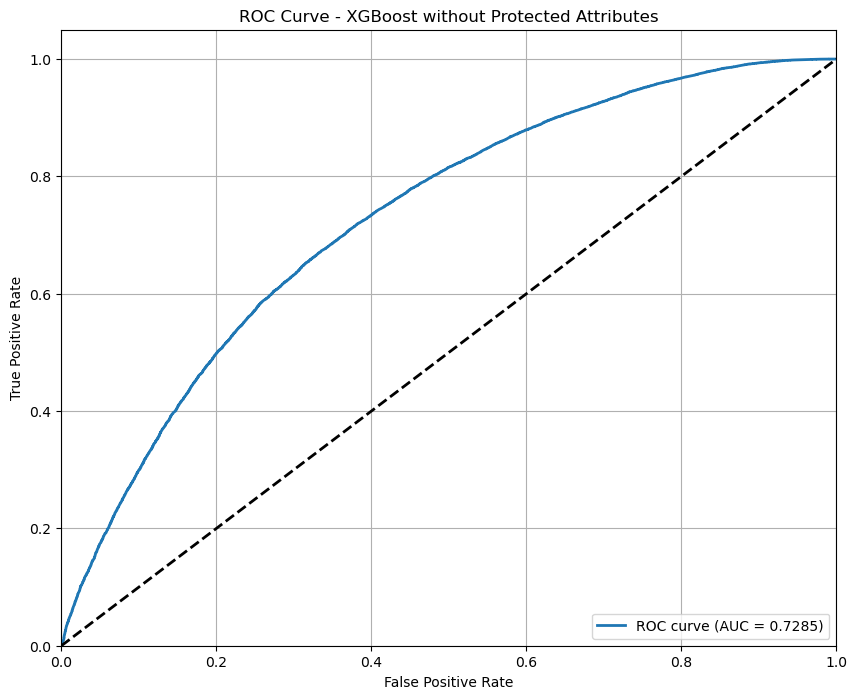

In [49]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                           roc_curve, auc, precision_recall_curve, average_precision_score)
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
import os
from xgboost import XGBClassifier

# 1. Load your existing split
X_train = pd.read_csv('data/training/X_train_processed.csv')
X_test = pd.read_csv('data/training/X_test_processed.csv')
y_train = pd.read_csv('data/training/y_train_processed.csv') 
y_test = pd.read_csv('data/training/y_test_processed.csv')

# Convert y to the right format if needed (assuming it's a single column DataFrame)
if y_train.shape[1] == 1:
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

# 2. List of protected attribute column names to remove
protected_cols = [
    # Race-related columns
    'applicant_race_American Indian or Alaska Native',
    'applicant_race_Asian',
    'applicant_race_Black or African American',
    'applicant_race_Native Hawaiian or Other Pacific Islander',
    'applicant_race_White',
    # Ethnicity-related columns
    'applicant_ethnicity_Hispanic or Latino',
    'applicant_ethnicity_Not Hispanic or Latino',
    'applicant_ethnicity_information not provided',
    # Sex-related columns
    'applicant_sex_Female',
    'applicant_sex_Male',
    # Region-related columns
    'region_Capital Region',
    'region_Central NY',
    'region_Finger Lakes',
    'region_Hudson Valley',
    'region_Long Island',
    'region_Mohawk Valley',
    'region_NYC',
    'region_North Country',
    'region_Southern Tier',
    'region_Western NY'
]

# 3. Create "no-protected Attributes" versions of feature data only
X_train_nr = X_train.drop(columns=protected_cols, errors='ignore')
X_test_nr = X_test.drop(columns=protected_cols, errors='ignore')

# No need to modify y_train and y_test as they should only contain the target labels

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name, sample_weights=None):
    """
    Train and evaluate model performance.
    
    Parameters:
    -----------
    model: The machine learning model to evaluate
    X_train, y_train: Training data
    X_test, y_test: Test data
    model_name: String name of the model for reporting
    sample_weights: Optional sample weights for training
    
    Returns:
    --------
    Dictionary of performance metrics, the trained model, and ROC curve data
    """
    # Start timer
    start_time = time.time()
    
    # Train model with or without weights
    if sample_weights is not None:
        model.fit(X_train, y_train, sample_weight=sample_weights)
        weight_status = "Weighted"
    else:
        model.fit(X_train, y_train)
        weight_status = "Unweighted"
        
    # End timer
    train_time = time.time() - start_time
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of class 1
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Calculate ROC AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Calculate PR AUC
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    
    # Cross-validation
    cv_scoring = 'roc_auc'
    cv_params = {'sample_weight': sample_weights} if sample_weights is not None else {}
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=cv_scoring,
                             fit_params=cv_params)
    
    # Print results
    print(f"\nModel: {model_name} ({weight_status})")
    print(f"Training Time: {train_time:.2f} seconds")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")
    print(f"CV ROC AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(f"Class 1 - Precision: {report['1']['precision']:.4f}, " 
          f"Recall: {report['1']['recall']:.4f}, "
          f"F1: {report['1']['f1-score']:.4f}")
    
    # Store results for return
    result = {
        'Model': f"{model_name} ({weight_status})",
        'Accuracy': accuracy,
        'ROC AUC': roc_auc,
        'PR AUC': pr_auc,
        'F1-Score': report['1']['f1-score'],
        'Precision': report['1']['precision'],
        'Recall': report['1']['recall'],
        'CV ROC AUC': cv_scores.mean(),
        'CV ROC AUC Std': cv_scores.std(),
        'Training Time': train_time
    }
    
    # Return the metrics, model, and ROC curve data
    return result, model, fpr, tpr

# 4. Initialize a fresh XGBoost classifier
no_race_xgb = XGBClassifier(
    n_estimators=100,
    random_state=42
)

# 5. Evaluate the model trained without protected attributes
results_nr, model_nr, fpr_nr, tpr_nr = evaluate_model(
    no_race_xgb,
    X_train_nr, y_train,  # Use X_train_nr but original y_train
    X_test_nr, y_test,    # Use X_test_nr but original y_test
    model_name='XGBoost No Protected',
    sample_weights=None
)

# 6. Save the trained model if needed
joblib.dump(model_nr, 'xgboost_no_protected.pkl')

# 7. Optionally, you can plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr_nr, tpr_nr, lw=2, label=f'ROC curve (AUC = {results_nr["ROC AUC"]:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost without Protected Attributes')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Model: XGBoost No Protected (Unweighted)
Training Time: 0.64 seconds
Accuracy: 0.8082
ROC AUC: 0.7285
PR AUC: 0.8955
CV ROC AUC: 0.7302 ± 0.0023
Class 1 - Precision: 0.8173, Recall: 0.9755, F1: 0.8894

Original class distribution:
1    0.790852
0    0.209148
dtype: float64

Class distribution after SMOTE:
1    0.5
0    0.5
dtype: float64

Model: XGBoost No Protected + SMOTE (Unweighted)
Training Time: 0.84 seconds
Accuracy: 0.7712
ROC AUC: 0.7129
PR AUC: 0.8882
CV ROC AUC: 0.8770 ± 0.0904
Class 1 - Precision: 0.8403, Recall: 0.8775, F1: 0.8585

Comparison of models:
                                       Model  Accuracy   ROC AUC    PR AUC  \
0          XGBoost No Protected (Unweighted)  0.808168  0.728529  0.895538   
1  XGBoost No Protected + SMOTE (Unweighted)  0.771229  0.712881  0.888204   

   F1-Score  Precision    Recall  
0  0.889415   0.817324  0.975454  
1  0.858501   0.840276  0.877534  


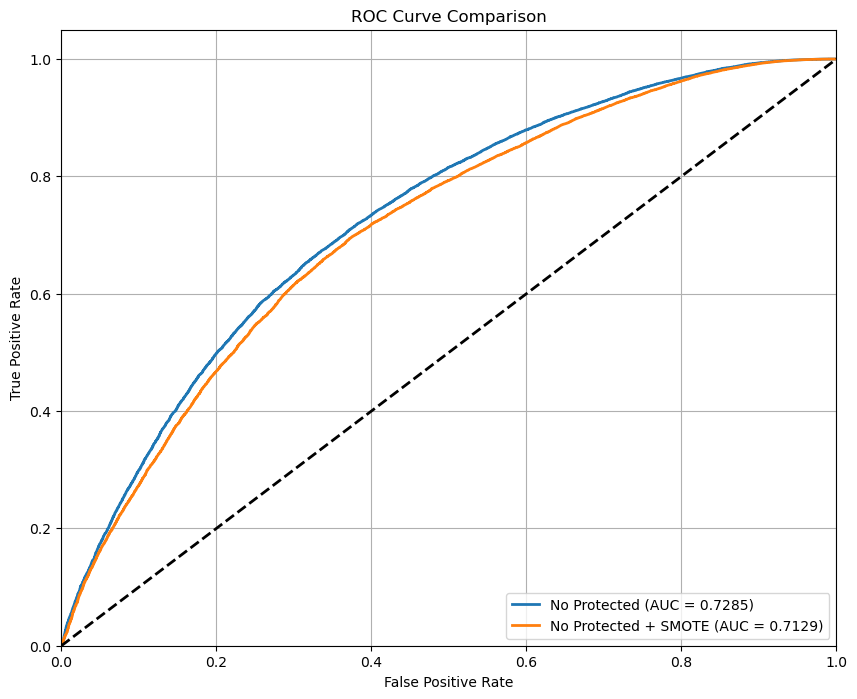

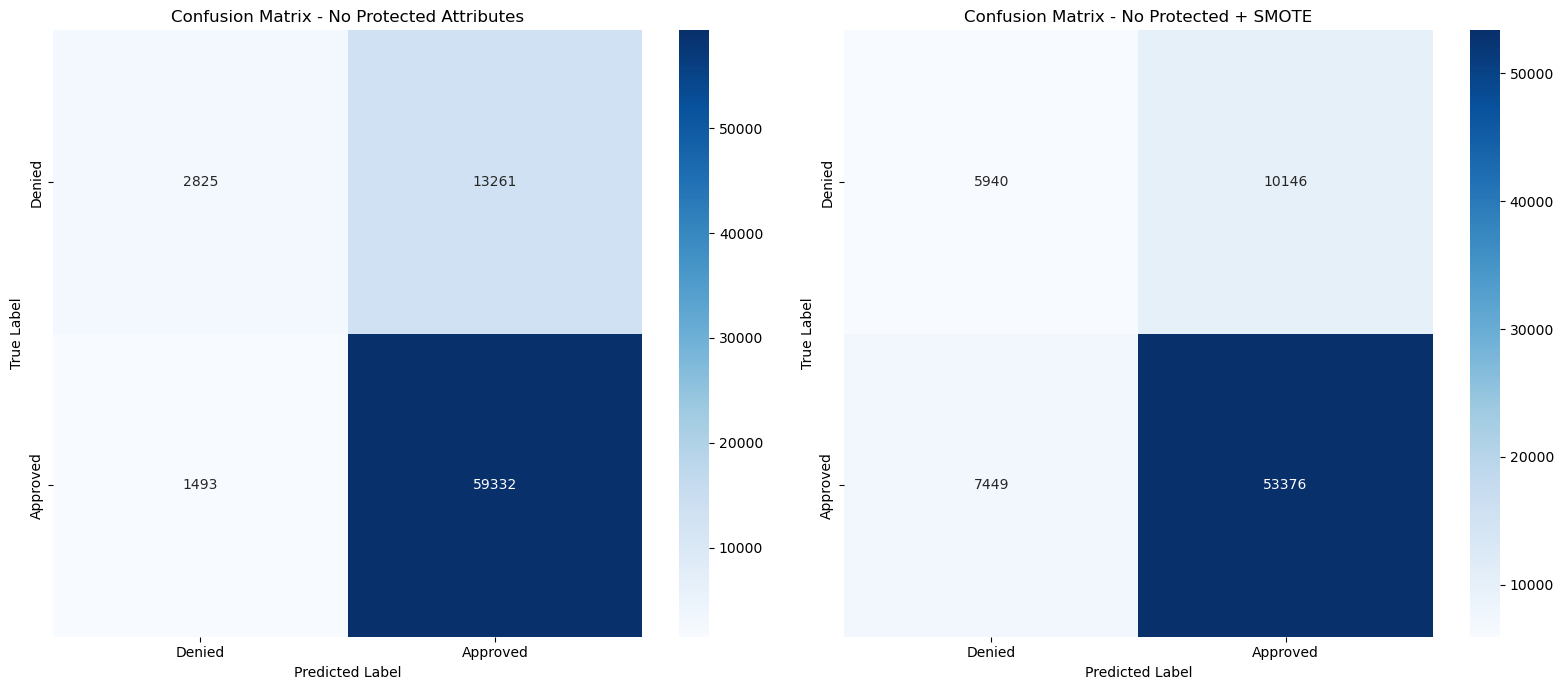


Detailed Confusion Matrix Metrics:
                Metric No Protected No Protected + SMOTE
0       True Negatives    2825.0000            5940.0000
1      False Positives   13261.0000           10146.0000
2      False Negatives    1493.0000            7449.0000
3       True Positives   59332.0000           53376.0000
4          Specificity       0.1756               0.3693
5   Sensitivity/Recall       0.9755               0.8775
6  False Positive Rate       0.8244               0.6307
7  False Negative Rate       0.0245               0.1225


In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                           roc_curve, auc, precision_recall_curve, average_precision_score)
import matplotlib.pyplot as plt
import seaborn as sns
import time
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# 1. Load your existing split (if not already in memory)
X_train = pd.read_csv('data/training/X_train_processed.csv')
X_test = pd.read_csv('data/training/X_test_processed.csv')
y_train = pd.read_csv('data/training/y_train_processed.csv') 
y_test = pd.read_csv('data/training/y_test_processed.csv')

# Convert y to the right format if needed
if y_train.shape[1] == 1:
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

# 2. List of protected attribute columns to remove
protected_cols = [
    # Race-related columns
    'applicant_race_American Indian or Alaska Native',
    'applicant_race_Asian',
    'applicant_race_Black or African American',
    'applicant_race_Native Hawaiian or Other Pacific Islander',
    'applicant_race_White',
    # Ethnicity-related columns
    'applicant_ethnicity_Hispanic or Latino',
    'applicant_ethnicity_Not Hispanic or Latino',
    'applicant_ethnicity_information not provided',
    # Sex-related columns
    'applicant_sex_Female',
    'applicant_sex_Male',
    # Region-related columns
    'region_Capital Region',
    'region_Central NY',
    'region_Finger Lakes',
    'region_Hudson Valley',
    'region_Long Island',
    'region_Mohawk Valley',
    'region_NYC',
    'region_North Country',
    'region_Southern Tier',
    'region_Western NY'
]

# 3. Create "no-protected attributes" version of feature data
X_train_nr = X_train.drop(columns=protected_cols, errors='ignore')
X_test_nr = X_test.drop(columns=protected_cols, errors='ignore')

# 4. Define the evaluation function with confusion matrix
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name, sample_weights=None):
    """
    Train and evaluate model performance.
    
    Parameters:
    -----------
    model: The machine learning model to evaluate
    X_train, y_train: Training data
    X_test, y_test: Test data
    model_name: String name of the model for reporting
    sample_weights: Optional sample weights for training
    
    Returns:
    --------
    Dictionary of performance metrics, the trained model, ROC curve data, and confusion matrix
    """
    # Start timer
    start_time = time.time()
    
    # Train model with or without weights
    if sample_weights is not None:
        model.fit(X_train, y_train, sample_weight=sample_weights)
        weight_status = "Weighted"
    else:
        model.fit(X_train, y_train)
        weight_status = "Unweighted"
        
    # End timer
    train_time = time.time() - start_time
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of class 1
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Calculate ROC AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Calculate PR AUC
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    
    # Cross-validation
    cv_scoring = 'roc_auc'
    cv_params = {'sample_weight': sample_weights} if sample_weights is not None else {}
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=cv_scoring,
                             fit_params=cv_params)
    
    # Print results
    print(f"\nModel: {model_name} ({weight_status})")
    print(f"Training Time: {train_time:.2f} seconds")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")
    print(f"CV ROC AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(f"Class 1 - Precision: {report['1']['precision']:.4f}, " 
          f"Recall: {report['1']['recall']:.4f}, "
          f"F1: {report['1']['f1-score']:.4f}")
    
    # Store results for return
    result = {
        'Model': f"{model_name} ({weight_status})",
        'Accuracy': accuracy,
        'ROC AUC': roc_auc,
        'PR AUC': pr_auc,
        'F1-Score': report['1']['f1-score'],
        'Precision': report['1']['precision'],
        'Recall': report['1']['recall'],
        'CV ROC AUC': cv_scores.mean(),
        'CV ROC AUC Std': cv_scores.std(),
        'Training Time': train_time
    }
    
    # Return the metrics, model, ROC curve data, and confusion matrix
    return result, model, fpr, tpr, conf_matrix

# 5. Train model without protected attributes (no SMOTE)
no_race_xgb = XGBClassifier(n_estimators=100, random_state=42)
results_nr, model_nr, fpr_nr, tpr_nr, cm_nr = evaluate_model(
    no_race_xgb,
    X_train_nr, y_train,
    X_test_nr, y_test,
    model_name='XGBoost No Protected',
    sample_weights=None
)

# 6. Apply SMOTE to balance the training dataset
smote = SMOTE(random_state=42)
X_train_nr_balanced, y_train_balanced = smote.fit_resample(X_train_nr, y_train)

# Print class distribution before and after SMOTE
print("\nOriginal class distribution:")
print(pd.Series(y_train).value_counts(normalize=True))
print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_balanced).value_counts(normalize=True))

# 7. Train model with SMOTE balanced data
balanced_xgb = XGBClassifier(n_estimators=100, random_state=42)
results_balanced, model_balanced, fpr_balanced, tpr_balanced, cm_balanced = evaluate_model(
    balanced_xgb,
    X_train_nr_balanced, y_train_balanced,
    X_test_nr, y_test,
    model_name='XGBoost No Protected + SMOTE',
    sample_weights=None
)

# 8. Compare metrics
print("\nComparison of models:")
comparison_df = pd.DataFrame([results_nr, results_balanced])
comparison_df = comparison_df[['Model', 'Accuracy', 'ROC AUC', 'PR AUC', 'F1-Score', 'Precision', 'Recall']]
print(comparison_df)

# 9. Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_nr, tpr_nr, lw=2, label=f'No Protected (AUC = {results_nr["ROC AUC"]:.4f})')
plt.plot(fpr_balanced, tpr_balanced, lw=2, label=f'No Protected + SMOTE (AUC = {results_balanced["ROC AUC"]:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True)
#plt.savefig('roc_curve_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 10. Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot for the model without SMOTE
sns.heatmap(cm_nr, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - No Protected Attributes')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_xticklabels(['Denied', 'Approved'])
axes[0].set_yticklabels(['Denied', 'Approved'])

# Plot for the model with SMOTE
sns.heatmap(cm_balanced, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix - No Protected + SMOTE')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_xticklabels(['Denied', 'Approved'])
axes[1].set_yticklabels(['Denied', 'Approved'])

plt.tight_layout()
#plt.savefig('confusion_matrix_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 11. Calculate additional metrics from confusion matrices
# For No SMOTE model
tn_nr, fp_nr, fn_nr, tp_nr = cm_nr.ravel()
specificity_nr = tn_nr / (tn_nr + fp_nr)
sensitivity_nr = tp_nr / (tp_nr + fn_nr)  # Same as recall
false_positive_rate_nr = fp_nr / (fp_nr + tn_nr)
false_negative_rate_nr = fn_nr / (fn_nr + tp_nr)

# For SMOTE model
tn_sm, fp_sm, fn_sm, tp_sm = cm_balanced.ravel()
specificity_sm = tn_sm / (tn_sm + fp_sm)
sensitivity_sm = tp_sm / (tp_sm + fn_sm)  # Same as recall
false_positive_rate_sm = fp_sm / (fp_sm + tn_sm)
false_negative_rate_sm = fn_sm / (fn_sm + tp_sm)

# Create detailed comparison table
detailed_metrics = pd.DataFrame({
    'Metric': ['True Negatives', 'False Positives', 'False Negatives', 'True Positives',
               'Specificity', 'Sensitivity/Recall', 'False Positive Rate', 'False Negative Rate'],
    'No Protected': [tn_nr, fp_nr, fn_nr, tp_nr, 
                     specificity_nr, sensitivity_nr, false_positive_rate_nr, false_negative_rate_nr],
    'No Protected + SMOTE': [tn_sm, fp_sm, fn_sm, tp_sm, 
                            specificity_sm, sensitivity_sm, false_positive_rate_sm, false_negative_rate_sm]
})

# Format numeric columns
for col in ['No Protected', 'No Protected + SMOTE']:
    detailed_metrics[col] = detailed_metrics[col].apply(lambda x: f"{x:.4f}" if isinstance(x, float) else x)

print("\nDetailed Confusion Matrix Metrics:")
print(detailed_metrics)